***Total: 42 points***

Complete this homework by writing R code to complete the following tasks. Keep in mind:

i. Empty chunks have been included where code is required
ii. For Problem 2e, you should include a image (screen shot), which can be loaded into R
iii. This homework requires use of data files:

  - `BRCA.genome_wide_snp_6_broad_Level_3_scna.seg` (Problems 1, 2)
  - `GIAB_highconf_v.3.3.2.vcf.gz` (Problem 3)
  
iv. You will be graded on your code and output results (knitted .html file). The assignment is worth 42 points total; partial credit can be awarded.

This assignment is due on **Dec 1, 2022**. 

For additional resources, please refer to these links:  
Problems 1 & 2:  
  - https://www.bioconductor.org/packages/devel/bioc/vignettes/plyranges/inst/doc/an-introduction.html
  - https://bioconductor.org/packages/release/bioc/vignettes/GenomicRanges/inst/doc/GenomicRangesIntroduction.html  
Problem 3:  
  - https://bioconductor.org/packages/release/bioc/vignettes/Rsamtools/inst/doc/Rsamtools-Overview.pdf  
Problem 4: 
  - https://bioconductor.org/packages/release/bioc/vignettes/VariantAnnotation/inst/doc/VariantAnnotation.pdf  

# Problem 1: Overlaps between genomic regions and copy number alterations. (14 points total)

### Preparation
Load copy number segment results as shown in *2.1 BED format* of *Lecture16_GenomicData.Rmd*. You will use the same file as in the lecture notes, `BRCA.genome_wide_snp_6_broad_Level_3_scna.seg`. Here is code to get you started.

In [1]:
#load packages
suppressPackageStartupMessages({
    library(tidyverse)
    library(GenomicRanges)
    library(plyranges)
    library(VariantAnnotation)
})

In [2]:
#old wdir
getwd()

#new wdir
data_dir = '/workspaces/tfcb_2022/lectures/lecture14/TFCB_data'
setwd(data_dir)
getwd()

[1] "/workspaces/tfcb_2022/homeworks/homework07"

[1] "/workspaces/tfcb_2022/lectures/lecture14/TFCB_data"

In [3]:
list.files()

[1] "BRCA_IDC_cfDNA.bam"                           
[2] "BRCA_IDC_cfDNA.bam.bai"                       
[3] "BRCA.genome_wide_snp_6_broad_Level_3_scna.seg"
[4] "GIAB_highconf_v.3.3.2.vcf.gz"                 
[5] "GIAB_highconf_v.3.3.2.vcf.gz.tbi"             
[6] "hs37d5.fa"                                    
[7] "hs37d5.fa.gz.fai"                             
[8] "screen_shot.png"

In [4]:
segs <- read.delim("BRCA.genome_wide_snp_6_broad_Level_3_scna.seg", as.is = TRUE)
mode(segs$Chromosome) <- "character" 
segs[segs$Chromosome == 23, "Chromosome"] <- "X"
segs.gr <- as(segs, "GRanges")

### a. Find the segments in `segs.gr` that have *any* overlap with the region `chr8:128,746,347-128,755,810` (4 points)
Print out the first five unique TCGA IDs.

In [6]:
seqinfo <- Seqinfo(genome = "hg19")
seqinfo <- keepStandardChromosomes(seqinfo) 
seqlevelsStyle(seqinfo) <- "NCBI"

slen <- seqlengths(seqinfo) # get the length of the chromosomes
tileWidth <- 500 # tile size 
tiles <- tileGenome(seqlengths = slen, tilewidth = tileWidth,
                    cut.last.tile.in.chrom = TRUE)

tiles.subset <- tiles[seqnames(tiles) == "8" & start(tiles) >= 128746347 & end(tiles) <= 128755810]

segs.overlap <- find_overlaps(segs.gr, tiles.subset)  

unique(segs.overlap$Sample)[1:5]


Warning message in (function (seqlevels, genome, new_style) :
“cannot switch some of hg19's seqlevels from UCSC to NCBI style”


[1] "TCGA-3C-AAAU-10A-01D-A41E-01" "TCGA-3C-AAAU-01A-11D-A41E-01"
[3] "TCGA-3C-AALI-10A-01D-A41E-01" "TCGA-3C-AALI-01A-11D-A41E-01"
[5] "TCGA-3C-AALJ-10A-01D-A41E-01"

### b. Find the mean of the `Segment_Mean` values for copy number segments that have *any* overlap with the region chr17:37,842,337-37,886,915. (4 points)

In [8]:
tiles.subset2 <- tiles[seqnames(tiles) == "17" & start(tiles) >= 37842337 & end(tiles) <= 37886915]

segs.overlap2 <- find_overlaps(segs.gr, tiles.subset2)  

mean(segs.overlap2$Segment_Mean)

[1] 0.1085545

### c. Find the patient sample distribution of copy number for `PIK3CA` (hg19). (6 points)
Find the counts of samples with deletion (D; `Segment_Mean < -0.3`), neutral (N; `Segment_Mean >= -0.3 & Segment_Mean <= 0.3`), gain (G; `Segment_Mean > 0.3`) segments that have `any` overlap with `PIK3CA` gene coordinates.  


In [15]:
#PIK3CA coords: chr3:178,866,311-178,952,497
tiles.subset3 <- tiles[seqnames(tiles) == "3" & start(tiles) >= 178866311 & end(tiles) <= 178952497]

segs.overlap3 <- find_overlaps(segs.gr, tiles.subset3)  

deletion<- segs.overlap3 %>% filter(Segment_Mean < -0.3) %>% group_by(Sample) %>% summarize(counts = n())
paste(nrow(deletion), "samples with deletions")

neutral<- segs.overlap3 %>% filter(Segment_Mean >= -0.3 & Segment_Mean <= 0.3 ) %>% group_by(Sample) %>% summarize(counts = n())
paste(nrow(neutral), "samples with neutral segments")

gain<- segs.overlap3 %>% filter(Segment_Mean > 0.3 ) %>% group_by(Sample) %>% summarize(counts = n())
paste(nrow(gain), "samples with gains")


[1] "17 samples with deletions"

[1] "2024 samples with neutral segments"

[1] "166 samples with gains"

# Problem 2: Frequency of copy number alteration events within genomic regions. (12 points total) 

This problem will continue to use the copy number data stored in `segs.gr`.

### a. Create a genome-wide tile of 1Mb windows for the human genome (`hg19`). (4 points)
See *3.1 Tiling the genome* of *Lecture16_GenomicData.Rmd* for hints.


In [16]:
slen <- seqlengths(seqinfo) # get the length of the chromosomes
tileWidth <- 1000000 # tile size 
tiles <- tileGenome(seqlengths = slen, tilewidth = tileWidth,
                    cut.last.tile.in.chrom = TRUE)
tiles

GRanges object with 3114 ranges and 0 metadata columns:
         seqnames            ranges strand
            <Rle>         <IRanges>  <Rle>
     [1]        1         1-1000000      *
     [2]        1   1000001-2000000      *
     [3]        1   2000001-3000000      *
     [4]        1   3000001-4000000      *
     [5]        1   4000001-5000000      *
     ...      ...               ...    ...
  [3110]        Y 56000001-57000000      *
  [3111]        Y 57000001-58000000      *
  [3112]        Y 58000001-59000000      *
  [3113]        Y 59000001-59373566      *
  [3114]     chrM           1-16571      *
  -------
  seqinfo: 25 sequences from an unspecified genome

### b. Find the 1Mb window with the most frequent overlapping deletions. (4 points)
Find the 1Mb windows with `any` overlap with deletion copy number segments. Assume a deletion segment is defined as a segment in `segs.gr` having `Segment_Mean < -0.3`. 

Return one of the 1Mb window `Granges` entry with the highest frequency (count) of deletion segments.

Hint: Subset the `segs.gr` to only rows with `Segment_Mean < -0.3`. 

In [17]:
segs.gr_del<- segs.gr %>% filter(Segment_Mean < -0.3) 
overlap<- countOverlaps(tiles, segs.gr_del)
tiles[which.max(overlap)]

GRanges object with 1 range and 0 metadata columns:
      seqnames            ranges strand
         <Rle>         <IRanges>  <Rle>
  [1]       16 79000001-80000000      *
  -------
  seqinfo: 25 sequences from an unspecified genome

### c. Visually inspect the deletion overlap result from part (b) using IGV. (4 points)
Provide a screen shot of IGV at the 1Mb window with the most frequent overlap with deletion segments. The image should include the segments from `BRCA.genome_wide_snp_6_broad_Level_3_scna.seg` loaded. 

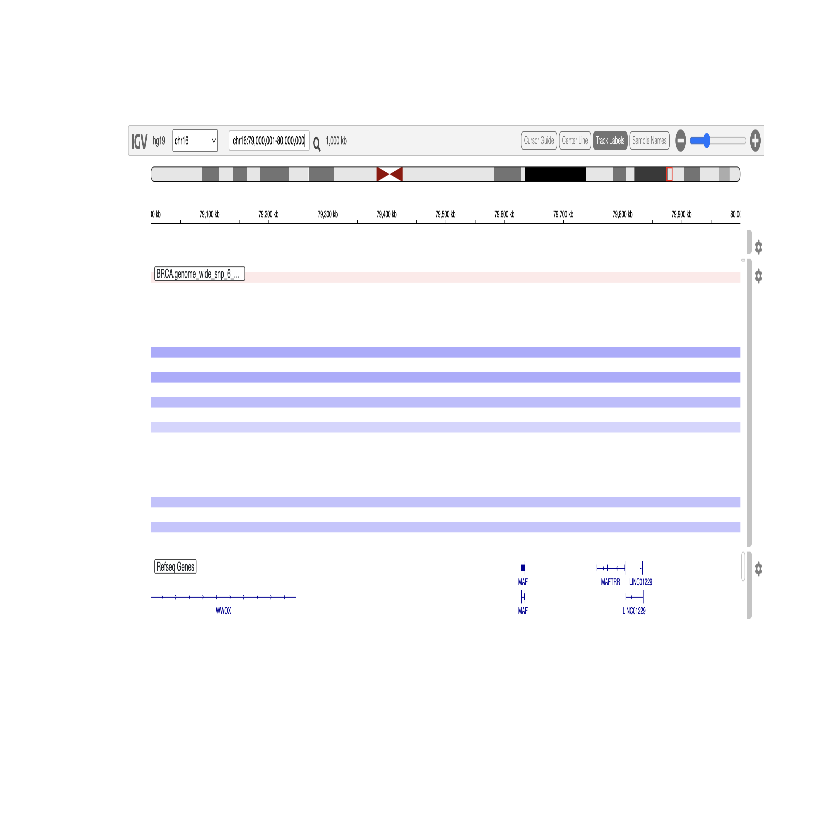

In [18]:
#save screenshot and load into R with png package (see: https://stackoverflow.com/questions/23861000/displaying-images-in-r-in-version-3-1-0)
#install.packages('png') #install if necessary 
library(png)
pp <- readPNG("screen_shot.png")
plot.new() 
rasterImage(pp,0,0,1,1)

# Problem 3: Reading and annotating genomic variants (16 points total)

### Preparation

In [19]:
vcfFile <- "GIAB_highconf_v.3.3.2.vcf.gz"

### a. Load variant data from VCF file `GIAB_highconf_v.3.3.2.vcf.gz` for `chr8:128,700,000-129,000,000`. (4 points)
Note: use genome build `hg19`.

In [20]:
vcfHead <- scanVcfHeader(vcfFile)
myGRange4 <- GRanges(seqnames = "8", ranges = IRanges(start = 128700000, end = 129000000))
vcf.param <- ScanVcfParam(which = myGRange4) 
vcf <- readVcf(vcfFile, genome = "hg19", param = vcf.param)

### b. Combine the fields of the VCF genotype information into a table. (4 points)
You may use your choice of data objects (e.g. `data.frame`).

In [21]:
genoData <- data.frame(do.call(cbind, geno(vcf)))
colnames(genoData) <- rownames(geno(header(vcf)))
genoData[1:10,]

,GT,DP,GQ,ADALL,AD,IGT,IPS,PS
,<named list>,<named list>,<named list>,<named list>,<named list>,<named list>,<named list>,<named list>
rs6984323,1|1,765,583,"1, 332","0, 315",1/1,.,PATMAT
rs4478537,0|1,544,813,"103, 124","135, 172",0/1,.,PATMAT
rs34141920,0|1,523,222,"132, 121","132, 121",0/1,.,PATMAT
rs17772814,1|0,695,1503,"143, 158","196, 199",0/1,.,PATMAT
rs77977256,1|0,642,685,"154, 157","160, 166",0/1,.,PATMAT
8:128715845_AT/A,0|1,368,99,"66, 91","66, 91",0/1,.,PATMAT
rs143209301,1|0,581,595,"128, 128","151, 165",0/1,.,PATMAT
rs202231913,0|1,369,99,"81, 97","81, 97",0/1,.,PATMAT
rs16902340,0|1,689,1294,"144, 150","184, 204",0/1,.,PATMAT


### c. Retrieve the following information at chr8:128747953. (8 points)
Print out the SNP ID (i.e. "rs ID"), reference base (`REF`), alterate base (`ALT`), genotype (`GT`), depth (`DP`), allele depth (`ADALL`), phase set (`PS`).

Hints: 

  i. `REF` and `ALT` are in the output of `rowRanges(vcf)`. See Section `3a` in `Lecture16_VariantCalls.ipynb` 
  ii. To get the sequence of `DNAString`, use `as.character(x)`.  
  ii. To get the sequence of `DNAStringSet`, use `as.character(unlist(x))`. 
  iii. To expand a list of information for `geno`, use `unlist(x)`.  

  

In [27]:
myGRange5 <- GRanges(seqnames = "8", ranges = IRanges(start = 128747953, end = 128747953))
vcf.param <- ScanVcfParam(which = myGRange5) 
vcf <- readVcf(vcfFile, genome = "hg19", param = vcf.param)

names(rowRanges(vcf))

as.character(unlist(ref(vcf)))
as.character(unlist(alt(vcf)))

unlist(geno(vcf))

geno(vcf)$GT[1]
geno(vcf)$DP[1]
geno(vcf)$ADALL[1] # or
unlist(geno(vcf)$ADALL)
geno(vcf)$PS[1]


[1] "rs3824120"

[1] "G"

[1] "T"

HG001   
GT.rs3824120    0|1     
DP.rs3824120    461     
GQ.rs3824120    668     
ADALL.rs3824120 105, 94 
AD.rs3824120    128, 121
IGT.rs3824120   0/1     
IPS.rs3824120   .       
PS.rs3824120    PATMAT

[1] "0|1"

[1] 461

[[1]]
[1] 105  94

[1] 105  94

[1] "PATMAT"